In [ ]:
import os

N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"


import jax.numpy as jnp
from jax import random, vmap
import jax
from jax.scipy.special import logit

from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

import Simulations.data_gen as dg
# import data_gen as dg
from src.MWG_sampler import MWG_sampler, MWG_init
import src.utils as utils
from src.Models import cond_logpost_a_star, triu_star_grad_fn
from src.MCMC_fixed_net import mcmc_fixed_net
import src.Models as models
import src.GWG as gwg

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'


# TODO: Think what traceplots to show in the supplement
# TODO: Think how to show convergence diagnostics, maybe ESS/sec or something like that 
# TODO: need to show how good is the approximation of the gradients in differing network sizes.
# TODO: Plot of $(n, Ess/second)$ or something else in y-axis that show efficiency of the method as n grows (scaleability in N)



In [8]:
# Global variables (as in mwg_simulation.py)

N = 500
TRIU_DIM = N * (N - 1) // 2

THETA = jnp.array([-2.5, 1])
GAMMA_BASELINE = jnp.array([logit(0.95), logit(0.05)])

GAMMA_REP = jnp.array([logit(0.8), 1.5, logit(0.2), 1.5])
GAMMA_X_NOISES = jnp.arange(2, 4 + 1e-6, 0.5)

GAMMA_B_NOISE_0 = GAMMA_BASELINE[0] - GAMMA_X_NOISES / 2
GAMMA_B_NOISE_1 = GAMMA_BASELINE[1] + GAMMA_X_NOISES / 2

# ETA = jnp.array([-1, 3, -0.5, 2])
ETA = jnp.array([-1, 3, -0.5, 1])
SIG_INV = 1.0
# SIG_INV = 2.0
RHO = 0.5
PZ = 0.5


PARAM = {
    "theta": THETA,
    "eta": ETA,
    "rho": RHO,
    "sig_inv": SIG_INV,
}

# Take mid value of GAMMA_X_NOISES for illustration

cur_gamma = jnp.concatenate(
                [
                    jnp.array([GAMMA_B_NOISE_0[2]]),
                    jnp.array([GAMMA_B_NOISE_1[2]]),
                    jnp.array([GAMMA_X_NOISES[2]]),
                    # GAMMA_REP,
                ]
            )

print(cur_gamma)



[ 1.4444387 -1.4444389  3.       ]


In [9]:
# rng_key = random.PRNGKey(1159)
rng_key = random.PRNGKey(0)

# generate data (not depedent on gamma)
rng_key, _ = random.split(rng_key)
fixed_data = dg.generate_fixed_data(rng_key, N, PARAM, PZ)

# true_vals for wasserstein distance
true_vals = {
    "eta": ETA,
    "rho": jnp.array([RHO]),
    "sig_inv": jnp.array([SIG_INV]),
    "triu_star": fixed_data["triu_star"],
}

print(f"mean true exposures: {jnp.mean(fixed_data['true_exposures']):.3f}")

# generate new interventions
rng_key, _ = random.split(rng_key)
new_interventions = dg.new_interventions_estimands(
    rng_key, N, fixed_data["x"], fixed_data["triu_star"], ETA
)

print(f"mean dynamic estimands: {jnp.mean(new_interventions.estimand_h):.3f}")
print(f"mean stochastic estimands: {jnp.mean(new_interventions.estimand_stoch):.3f}")
print(f"mean gate estimands: {jnp.mean(new_interventions.estimand_gate):.3f}")

mean true exposures: 12.200
mean dynamic estimands: 16.258
mean stochastic estimands: 19.841
mean gate estimands: 50.156


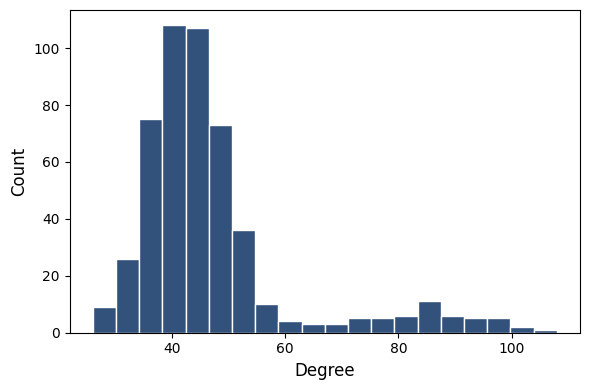

In [10]:
# plot true network degree distribution
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['axes.labelsize'] = 'medium'


true_degs = jnp.sum(utils.Triu_to_mat(fixed_data["triu_star"]), axis=1)

plt.figure(figsize=(6, 4))
plt.hist(true_degs, bins=20, color="#32527b", edgecolor="white")

plt.xlabel("Degree", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.gca().set_facecolor("white")  # Ensure background is white

plt.tight_layout()



# plt.savefig("Simulations/results/figs/degree_hist.png", 
            # dpi=300,
            # bbox_inches="tight")

plt.show()

(array([  9.,  26.,  75., 108., 107.,  73.,  36.,  10.,   4.,   3.,   3.,
          5.,   5.,   6.,  11.,   6.,   5.,   5.,   2.,   1.]),
 array([0.15631263, 0.18096192, 0.20561123, 0.23026052, 0.25490981,
        0.27955914, 0.3042084 , 0.32885772, 0.35350701, 0.3781563 ,
        0.40280563, 0.42745489, 0.45210421, 0.47675347, 0.5014028 ,
        0.52605212, 0.55070138, 0.5753507 , 0.59999996, 0.62464929,
        0.64929861]),
 <BarContainer object of 20 artists>)

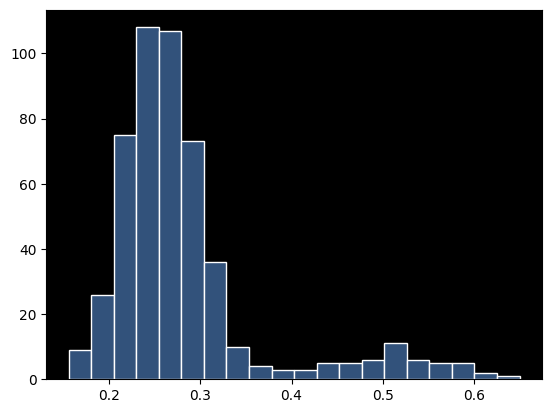

In [11]:
plt.hist(3*true_degs/(N-1), bins=20, color="#32527b", edgecolor="white")
# plt.hist(fixed_data["true_exposures"], bins=20, color="#32527b", edgecolor="white")
# plt.hist(fixed_data["true_exposures"], bins=20, color="#32527b", edgecolor="white")



In [12]:
rng_key = random.split(rng_key)[0]
# sample proxy networks with current gamma
proxy_nets = dg.generate_proxy_networks(
    # rng,
    rng_key,
    TRIU_DIM,
    fixed_data["triu_star"],
    cur_gamma,
    fixed_data["x_diff"],
    fixed_data["Z"],
)

data_sim = dg.data_for_sim(fixed_data, proxy_nets)


In [13]:
rng_key = random.split(rng_key)[0]
    # --- fixed true network ---
mcmc_true = mcmc_fixed_net(
rng_key=rng_key,
data=data_sim,
net_type="true",
num_chains=4,
progress_bar=True,
)

true_net_dynamic_stats = mcmc_true.new_intervention_error_stats(
new_z=new_interventions.Z_h,
    true_estimands=new_interventions.estimand_h,
    true_vals=true_vals,
)

true_net_gate_stats = mcmc_true.new_intervention_error_stats(
    new_z=new_interventions.Z_gate,
    true_estimands=new_interventions.estimand_gate,
    true_vals=true_vals,
)

rng_key = random.split(rng_key)[0]

mcmc_obs = mcmc_fixed_net(
    rng_key=rng_key,
    data=data_sim,
    net_type="obs",
    # n_warmup=500,
    # n_samples=500,
    num_chains=4,
    progress_bar=True,
)

obs_net_dynamic_stats = mcmc_obs.new_intervention_error_stats(
    new_z=new_interventions.Z_h,
    true_estimands=new_interventions.estimand_h,
    true_vals=true_vals,
)

obs_net_gate_stats = mcmc_obs.new_intervention_error_stats(
    new_z=new_interventions.Z_gate,
    true_estimands=new_interventions.estimand_gate, 
    true_vals=true_vals,
)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:00<?, ?it/s]




Running chain 0:  55%|█████▌    | 3300/6000 [00:00<00:00, 15892.79it/s]


Running chain 0:  80%|████████  | 4800/6000 [00:00<00:00, 13264.37it/s]


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 0:  20%|██        | 1200/6000 [00:00<00:00, 5772.96it/s]




Running chain 0:  40%|████      | 2400/6000 [00:00<00:00, 7890.40it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [00:01<00:00, 6676.40it/s]



Running chain 0:  70%|███████   | 4200/6000 [00:01<00:00, 6542.54it/s]


Running chain 0:  85%|████████▌ | 5100/6000 [00:01<00:00, 5702.60it/s]


Running chain 2: 100%|██████████| 6000/6000 [00:01<00:00, 4171.01it/s]


Running chain 1: 100%|██████████| 6000/6000 [00:01<00:00, 3744.78it/s]


In [14]:
true_net_dynamic_stats, obs_net_dynamic_stats

({'mean': Array(16.287819, dtype=float32),
  'median': Array(15.460509, dtype=float32),
  'true': Array(16.258, dtype=float32),
  'bias': Array(0.02982, dtype=float32),
  'std': Array(0.15751, dtype=float32),
  'RMSE': Array(0.1603, dtype=float32),
  'RMSE_rel': Array(0.00986, dtype=float32),
  'MAE': Array(0.06962, dtype=float32),
  'MAPE': Array(0.00451, dtype=float32),
  'q025': Array(15.981537, dtype=float32),
  'q975': Array(16.598253, dtype=float32),
  'covering': Array(True, dtype=bool),
  'mean_ind_cover': Array(1., dtype=float32),
  'w_dist': Array(0.25962994, dtype=float32)},
 {'mean': Array(7.06848, dtype=float32),
  'median': Array(7.06383, dtype=float32),
  'true': Array(16.258, dtype=float32),
  'bias': Array(-9.18952, dtype=float32),
  'std': Array(2.1587598, dtype=float32),
  'RMSE': Array(9.43968, dtype=float32),
  'RMSE_rel': Array(0.58062, dtype=float32),
  'MAE': Array(9.21566, dtype=float32),
  'MAPE': Array(0.53765, dtype=float32),
  'q025': Array(2.8981776, dtype

In [9]:
true_net_gate_stats, obs_net_gate_stats

({'mean': Array(50.248077, dtype=float32),
  'median': Array(46.67745, dtype=float32),
  'true': Array(50.156, dtype=float32),
  'bias': Array(0.09208, dtype=float32),
  'std': Array(0.45319998, dtype=float32),
  'RMSE': Array(0.46245998, dtype=float32),
  'RMSE_rel': Array(0.00922, dtype=float32),
  'MAE': Array(0.09219, dtype=float32),
  'MAPE': Array(0.00167, dtype=float32),
  'q025': Array(49.36242, dtype=float32),
  'q975': Array(51.13474, dtype=float32),
  'covering': Array(True, dtype=bool),
  'mean_ind_cover': Array(1., dtype=float32),
  'w_dist': Array(0.25962994, dtype=float32)},
 {'mean': Array(20.79214, dtype=float32),
  'median': Array(20.64934, dtype=float32),
  'true': Array(50.156, dtype=float32),
  'bias': Array(-29.36386, dtype=float32),
  'std': Array(6.24784, dtype=float32),
  'RMSE': Array(30.021189, dtype=float32),
  'RMSE_rel': Array(0.59856, dtype=float32),
  'MAE': Array(29.36386, dtype=float32),
  'MAPE': Array(0.56162, dtype=float32),
  'q025': Array(8.673064

In [15]:
# --- MWG init params (single proxy) ---

# rng_key = random.split(rng_key)[1]
# mwg_init = MWG_init(
#     rng_key=rng_key,
#     data=data_sim,
#     cut_posterior_net_model=models.networks_marginalized_model_rep,
#     triu_star_log_posterior_fn=models.compute_log_posterior_vmap_rep,
#     progress_bar=True,
# ).get_init_values()

# # --- Sampling with MWG (single proxy) ---

# rng_key = random.split(rng_key)[1]

# mwg_sampler = MWG_sampler(
#     rng_key=rng_key,
#     data=data_sim,
#     init_params=mwg_init,
#      gwg_fn=gwg.make_gwg_gibbs_fn_rep_no_z,
#     combined_model=models.combined_model_rep,
#     progress_bar=True, 
#     # n_warmup=1000,
#     # n_samples=1000,
#     n_warmup=3000,
#     n_samples=3000,
# )

# mwg_sampler = MWG_sampler(
#     rng_key=rng_key,
#     data=data_sim,
#     init_params=mwg_init,
#      gwg_fn=gwg.make_gwg_gibbs_fn_rep,
#     combined_model=models.combined_model_rep,
#     progress_bar=True, 
#     # n_warmup=1000,
#     # n_samples=1000,
#     n_warmup=3000,
#     n_samples=3000,
# )
# --- MWG init params (single proxy) ---

rng_key = random.split(rng_key)[1]
mwg_init = MWG_init(
    rng_key=rng_key,
    data=data_sim,
    cut_posterior_net_model=models.networks_marginalized_model_misspec,
    triu_star_log_posterior_fn=models.compute_log_posterior_vmap_misspec,
    progress_bar=True,
    misspecified=True,
).get_init_values()

# --- Sampling with MWG (single proxy) ---

rng_key = random.split(rng_key)[1]

mwg_sampler = MWG_sampler(
    rng_key=rng_key,
    data=data_sim,
    init_params=mwg_init,
     gwg_fn=gwg.make_gwg_gibbs_fn_misspec,
    combined_model=models.combined_model_misspec,
    progress_bar=True, 
    misspecified=True,
    # n_warmup=1000,
    # n_samples=1000,
    n_warmup=3000,
    n_samples=3000,
)



Initializing parameters for MWG sampler...


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:01<?, ?it/s]


Running chain 0:   5%|▌         | 300/6000 [00:28<08:36, 11.04it/s]




Running chain 0:  10%|█         | 600/6000 [00:44<06:14, 14.42it/s]


Running chain 0:  15%|█▌        | 900/6000 [01:01<05:17, 16.04it/s]





Running chain 0:  15%|█▌        | 900/6000 [01:11<05:17, 16.04it/s]

Running chain 0:  20%|██        | 1200/6000 [01:17<04:46, 16.73it/s]





Running chain 0:  25%|██▌       | 1500/6000 [01:33<04:18, 17.40it/s]




Running chain 0:  30%|███       | 1800/6000 [01:49<03:55, 17.87it/s]





Running chain 0:  30%|███       | 1800/6000 [02:01<03:55, 17.87it/s]


Running chain 0:  35%|███▌      | 2100/6000 [02:05<03:35, 18.13it/s]



Running chain 0:  40%|████      | 2400/6000 [02:21<03:16, 18.35it/s]



Running chain 0:  40%|████      | 2400/6000 [02:34<03:16, 18.35it/s]

Running chain 0:  45%|████▌     | 2700/6000 [02:37<02:57, 18.62it/s]



Running chain 0:  

In [16]:
mwg_init

{'eta': Array([[1.1657019 , 3.81497   , 0.10510354],
        [1.1657019 , 3.81497   , 0.10510354],
        [1.1657019 , 3.81497   , 0.10510354],
        [1.1657019 , 3.81497   , 0.10510354]], dtype=float32),
 'gamma': Array([[ 1.6105291, -0.8878442],
        [ 1.6105291, -0.8878442],
        [ 1.6105291, -0.8878442],
        [ 1.6105291, -0.8878442]], dtype=float32),
 'sig_inv': Array([4.5535665, 4.5535665, 4.5535665, 4.5535665], dtype=float32),
 'theta': Array([[1.2708085 , 0.16659603],
        [1.2708085 , 0.16659603],
        [1.2708085 , 0.16659603],
        [1.2708085 , 0.16659603]], dtype=float32),
 'triu_star': Array([[1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 1, 1]], dtype=int32)}

In [17]:
mwg_sampler.print_diagnostics()


=== MCMC Diagnostics (NUTS) ===
Total Sampling Time: 1.29 seconds

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.98      2.38      0.96     -3.03      4.76     99.92      1.01
    eta[1]      3.81      0.47      3.81      3.03      4.59   5514.89      1.00
    eta[2]      0.11      0.03      0.11      0.06      0.15     89.35      1.02
  gamma[0]      1.64      0.03      1.64      1.59      1.68      8.60      1.05
  gamma[1]     -0.84      0.06     -0.87     -0.93     -0.73      8.75      1.42
   sig_inv      4.53      0.15      4.53      4.30      4.79   7167.13      1.00
  theta[0]      1.21      0.02      1.21      1.18      1.24      7.04      1.39
  theta[1]      0.19      0.03      0.19      0.14      0.23     47.94      1.00


--- Efficiency Metrics (ESS / sec) ---
eta        | Mean ESS: 1901.4 | Efficiency: 1473.19 samples/sec
gamma      | Mean ESS: 8.7 | Efficiency: 6.72 samples/sec
sig_inv    | Mean ESS: 7167.1 | Efficien

In [19]:
esti_triu_star = mwg_init["triu_star"][0,:]
esti_exposures = utils.compute_exposures(esti_triu_star, data_sim.Z)

data_two_stage = data_sim._replace(
    true_exposures=esti_exposures,
      triu_star=esti_triu_star)

rng_key = random.split(rng_key)[0]
# --- fixed estimated network (two-stage) ---
mcmc_two_stage = mcmc_fixed_net(
rng_key=rng_key,
data=data_two_stage,
net_type="true",
num_chains=4,
progress_bar=True,
)
two_stage_dynamic_stats = mcmc_two_stage.new_intervention_error_stats(
new_z=new_interventions.Z_h,
    true_estimands=new_interventions.estimand_h,
    true_vals=true_vals,
)

two_stage_gate_stats = mcmc_two_stage.new_intervention_error_stats(
    new_z=new_interventions.Z_gate,
    true_estimands=new_interventions.estimand_gate,
    true_vals=true_vals,
)

two_stage_dynamic_stats, two_stage_gate_stats 


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 0:  25%|██▌       | 1500/6000 [00:00<00:00, 13311.19it/s]


Running chain 0:  55%|█████▌    | 3300/6000 [00:00<00:00, 15721.53it/s]


Running chain 1: 100%|██████████| 6000/6000 [00:00<00:00, 6822.53it/s] 


Running chain 2: 100%|██████████| 6000/6000 [00:00<00:00, 6719.58it/s] 








Running chain 3: 100%|██████████| 6000/6000 [00:01<00:00, 4392.40it/s]


({'mean': Array(8.89786, dtype=float32),
  'median': Array(8.77577, dtype=float32),
  'true': Array(16.258, dtype=float32),
  'bias': Array(-7.36014, dtype=float32),
  'std': Array(0.6892, dtype=float32),
  'RMSE': Array(7.3923297, dtype=float32),
  'RMSE_rel': Array(0.45468998, dtype=float32),
  'MAE': Array(7.43386, dtype=float32),
  'MAPE': Array(0.4436, dtype=float32),
  'q025': Array(7.565042, dtype=float32),
  'q975': Array(10.243968, dtype=float32),
  'covering': Array(False, dtype=bool),
  'mean_ind_cover': Array(0.824, dtype=float32),
  'w_dist': Array(9.175187, dtype=float32)},
 {'mean': Array(27.14604, dtype=float32),
  'median': Array(25.899, dtype=float32),
  'true': Array(50.156, dtype=float32),
  'bias': Array(-23.00996, dtype=float32),
  'std': Array(1.96409, dtype=float32),
  'RMSE': Array(23.09364, dtype=float32),
  'RMSE_rel': Array(0.46043998, dtype=float32),
  'MAE': Array(23.00997, dtype=float32),
  'MAPE': Array(0.44854, dtype=float32),
  'q025': Array(23.263107,

In [18]:
# Run with two-stage
esti_triu_star = mwg_init["triu_star"][0,:]
print(esti_triu_star.shape)
esti_exposures = utils.compute_exposures(esti_triu_star, data_sim.Z)

fixed_data_copy = fixed_data.copy()
fixed_data_copy["true_exposures"] = esti_exposures
fixed_data_copy["triu_star"] = esti_triu_star

data_sim_twostage = dg.data_for_sim(fixed_data_copy, proxy_nets)

rng_key = random.split(rng_key)[0]
    # --- fixed true network ---
mcmc_twostage = mcmc_fixed_net(
rng_key=rng_key,
data=data_sim_twostage,
net_type="true",
num_chains=4,
progress_bar=True,
)

twostage_dynamic_stats = mcmc_twostage.new_intervention_error_stats(
new_z=new_interventions.Z_h,
    true_estimands=new_interventions.estimand_h,
    true_vals=true_vals,
)

twostage_gate_stats = mcmc_twostage.new_intervention_error_stats(
    new_z=new_interventions.Z_gate,
    true_estimands=new_interventions.estimand_gate,
    true_vals=true_vals,
)

twostage_dynamic_stats, twostage_gate_stats

(124750,)


Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 0:   5%|▌         | 300/6000 [00:00<00:02, 2567.77it/s]


Running chain 0:  15%|█▌        | 900/6000 [00:00<00:01, 4311.17it/s]


Running chain 0:  30%|███       | 1800/6000 [00:00<00:00, 5863.67it/s]


Running chain 0:  45%|████▌     | 2700/6000 [00:00<00:00, 6721.80it/s]


Running chain 0:  60%|██████    | 3600/6000 [00:01<00:00, 6364.71it/s]


Running chain 0:  75%|███████▌  | 4500/6000 [00:01<00:00, 6095.11it/s]


Running chain 0:  85%|████████▌ | 5100/6000 [00:01<00:00, 5929.49it/s]


Running chain 1: 100%|██████████| 6000/6000 [00:01<00:00, 3771.61it/s]

Running chain 2: 100%|██████████| 6000/6000 [00:01<00:00, 3677.36it/s]


({'mean': Array(13.828219, dtype=float32),
  'median': Array(13.81804, dtype=float32),
  'true': Array(16.258, dtype=float32),
  'bias': Array(-2.42978, dtype=float32),
  'std': Array(2.86325, dtype=float32),
  'RMSE': Array(3.75526, dtype=float32),
  'RMSE_rel': Array(0.23098, dtype=float32),
  'MAE': Array(4.00935, dtype=float32),
  'MAPE': Array(0.249, dtype=float32),
  'q025': Array(8.242595, dtype=float32),
  'q975': Array(19.50713, dtype=float32),
  'covering': Array(True, dtype=bool),
  'mean_ind_cover': Array(0.944, dtype=float32),
  'w_dist': Array(7.6007576, dtype=float32)},
 {'mean': Array(41.63081, dtype=float32),
  'median': Array(41.51976, dtype=float32),
  'true': Array(50.156, dtype=float32),
  'bias': Array(-8.525189, dtype=float32),
  'std': Array(8.569389, dtype=float32),
  'RMSE': Array(12.087729, dtype=float32),
  'RMSE_rel': Array(0.241, dtype=float32),
  'MAE': Array(10.17287, dtype=float32),
  'MAPE': Array(0.16835, dtype=float32),
  'q025': Array(24.925879, dty

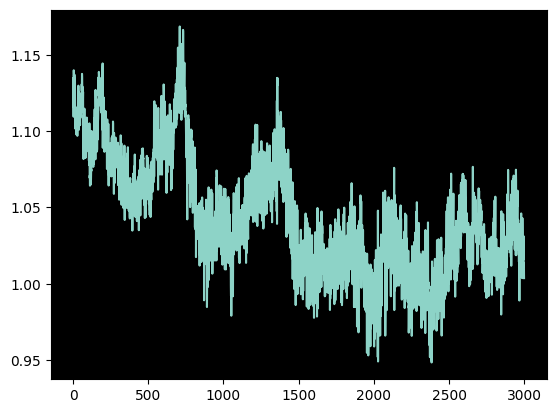

In [13]:
# plt.plot(mwg_sampler.posterior_samples["eta"][:,:,3])
# plt.plot(mwg_sampler.posterior_samples["eta"][:,3])
# plt.plot(mwg_sampler.posterior_samples["eta"][0:3000,3])
# plt.plot(mwg_sampler.posterior_samples["eta"][3000:6000,3])
plt.plot(mwg_sampler.posterior_samples["eta"][9000:12000,3])

# plt.plot(mwg_sampler.posterior_samples["sig_inv"])
# plt.plot(mwg_sampler.posterior_samples["theta"][0:3000:,1])


In [19]:
mwg_dynamic_stats = mwg_sampler.new_intervention_error_stats(
        new_z=new_interventions.Z_h,
        true_estimands=new_interventions.estimand_h,
        true_vals=true_vals,
    )

mwg_gate_stats = mwg_sampler.new_intervention_error_stats(
        new_z=new_interventions.Z_gate,
        true_estimands=new_interventions.estimand_gate,
        true_vals=true_vals,
    )
mwg_dynamic_stats, mwg_gate_stats

({'mean': Array(15.00394, dtype=float32),
  'median': Array(15.01087, dtype=float32),
  'true': Array(16.258, dtype=float32),
  'bias': Array(-1.2540599, dtype=float32),
  'std': Array(3.2826898, dtype=float32),
  'RMSE': Array(3.5140698, dtype=float32),
  'RMSE_rel': Array(0.21613999, dtype=float32),
  'MAE': Array(3.75751, dtype=float32),
  'MAPE': Array(0.25242, dtype=float32),
  'q025': Array(8.521941, dtype=float32),
  'q975': Array(21.284426, dtype=float32),
  'covering': Array(True, dtype=bool),
  'mean_ind_cover': Array(0.96199995, dtype=float32),
  'w_dist': 999.0},
 {'mean': Array(45.114758, dtype=float32),
  'median': Array(45.07092, dtype=float32),
  'true': Array(50.156, dtype=float32),
  'bias': Array(-5.0412397, dtype=float32),
  'std': Array(9.815849, dtype=float32),
  'RMSE': Array(11.03471, dtype=float32),
  'RMSE_rel': Array(0.22001, dtype=float32),
  'MAE': Array(8.85122, dtype=float32),
  'MAPE': Array(0.14989999, dtype=float32),
  'q025': Array(25.714869, dtype=fl

Mean posterior exposure: 11.442
True exposure: 12.200


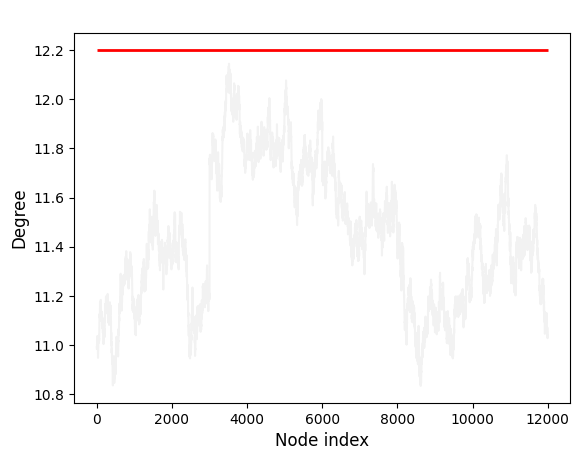

: 

: 

In [ ]:
post_expos = utils.vmap_compute_exposures(mwg_sampler.posterior_samples["triu_star"], fixed_data["Z"])
post_expos.mean(axis=1).shape

true_expos = fixed_data["true_exposures"]

print(f"Mean posterior exposure: {jnp.mean(post_expos.mean(axis=1)):.3f}")
print(f"True exposure: {jnp.mean(true_expos):.3f}")

plt.plot(post_expos.mean(axis=1), alpha=0.1, color="gray")
plt.hlines(true_expos.mean(), xmin=0, xmax=post_expos.shape[0], color="red", linewidth=2)
plt.xlabel("Node index", fontsize=12)
plt.ylabel("Degree", fontsize=12)
plt.title("Posterior sampled degrees vs. True degrees", fontsize=14)
plt.gca().set_facecolor("white")  # Ensure background is white



(12000, 500)
Mean posterior dynamic estimand: 15.851
True dynamic estimand: 16.258


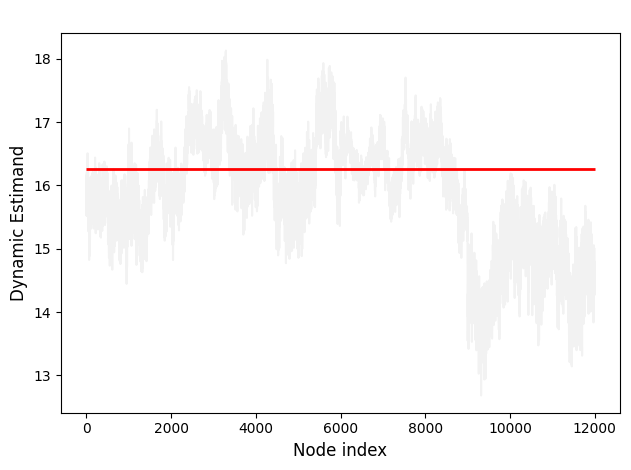

: 

: 

In [ ]:
mwg_dynamic_esti = mwg_sampler.sample_pred_y(
    new_z=new_interventions.Z_h,
)

print(mwg_dynamic_esti.shape)
true_esi = new_interventions.estimand_h

print(f"Mean posterior dynamic estimand: {jnp.mean(mwg_dynamic_esti.mean(axis=1)):.3f}")
print(f"True dynamic estimand: {jnp.mean(true_esi):.3f}")

plt.plot(mwg_dynamic_esti.mean(axis=1), alpha=0.1, color="gray")
plt.hlines(true_esi.mean(), xmin=0, xmax=mwg_dynamic_esti.shape[0], color="red", linewidth=2)
plt.xlabel("Node index", fontsize=12)
plt.ylabel("Dynamic Estimand", fontsize=12)
plt.title("Posterior sampled dynamic estimands vs. True estimands", fontsize=14)
plt.gca().set_facecolor("white")  # Ensure background is white  
plt.tight_layout()

(12000, 500)
Mean posterior gate estimand: 48.789
True gate estimand: 50.156


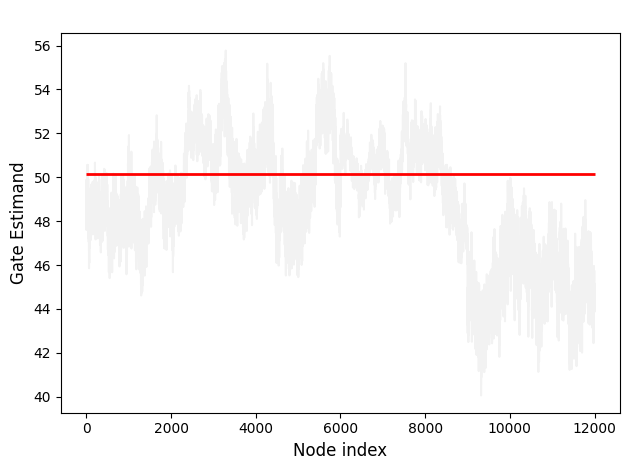

: 

: 

In [ ]:
mwg_gate_esti = mwg_sampler.sample_pred_y(
    new_z=new_interventions.Z_gate,
)

print(mwg_gate_esti.shape)
true_esi = new_interventions.estimand_gate

print(f"Mean posterior gate estimand: {jnp.mean(mwg_gate_esti.mean(axis=1)):.3f}")
print(f"True gate estimand: {jnp.mean(true_esi):.3f}")

plt.plot(mwg_gate_esti.mean(axis=1), alpha=0.1, color="gray")
plt.hlines(true_esi.mean(), xmin=0, xmax=mwg_gate_esti.shape[0], color="red", linewidth=2)
plt.xlabel("Node index", fontsize=12)
plt.ylabel("Gate Estimand", fontsize=12)
plt.title("Posterior sampled gate estimands vs. True estimands", fontsize=14)
plt.gca().set_facecolor("white")  # Ensure background is white  
plt.tight_layout()

In [ ]:
post_mean_probs = jnp.mean(mwg_sampler.posterior_samples["triu_star"], axis=0)

# Save and read for later
# np_post_probs = np.asarray(post_mean_probs)
# np.savetxt("Simulations/results/post_triu_star_prob.txt", np_post_probs)
# 
# post_mean_probs = np.loadtxt("Simulations/results/post_triu_star_prob.txt")

# post_mean_probs = np.loadtxt("results/post_triu_star_prob.txt")
# post_edges = jnp.where(post_mean_probs > 1/3, 1, 0)
# post_edges = jnp.where(post_mean_probs > .25, 1, 0)
post_edges = jnp.where(post_mean_probs > .5, 1, 0)


: 

: 

In [ ]:
true_net = utils.Triu_to_mat(data_sim.triu_star)
# obs_net = utils.Triu_to_mat(data_sim.triu_obs_rep)
obs_net = utils.Triu_to_mat(data_sim.triu_obs)
post_mean = utils.Triu_to_mat(post_edges)
post_mean_prob = utils.Triu_to_mat(post_mean_probs)

: 

: 

In [ ]:
# Order edges by hierarchical clustering for clearer visualization

true_net_np = np.array(true_net)  

distances = pdist(true_net_np, metric='euclidean') 
Z = linkage(distances, method='ward')            

node_order = leaves_list(Z)                     

#  Apply the ordering to rows and columns in all matrices 
node_order_jax = jnp.array(node_order)

true_ordered = true_net[node_order_jax][:, node_order_jax]
observed_ordered = obs_net[node_order_jax][:, node_order_jax]
posterior_ordered = post_mean[node_order_jax][:, node_order_jax]
posterior_ordered_prob = post_mean_prob[node_order_jax][:, node_order_jax]



: 

: 

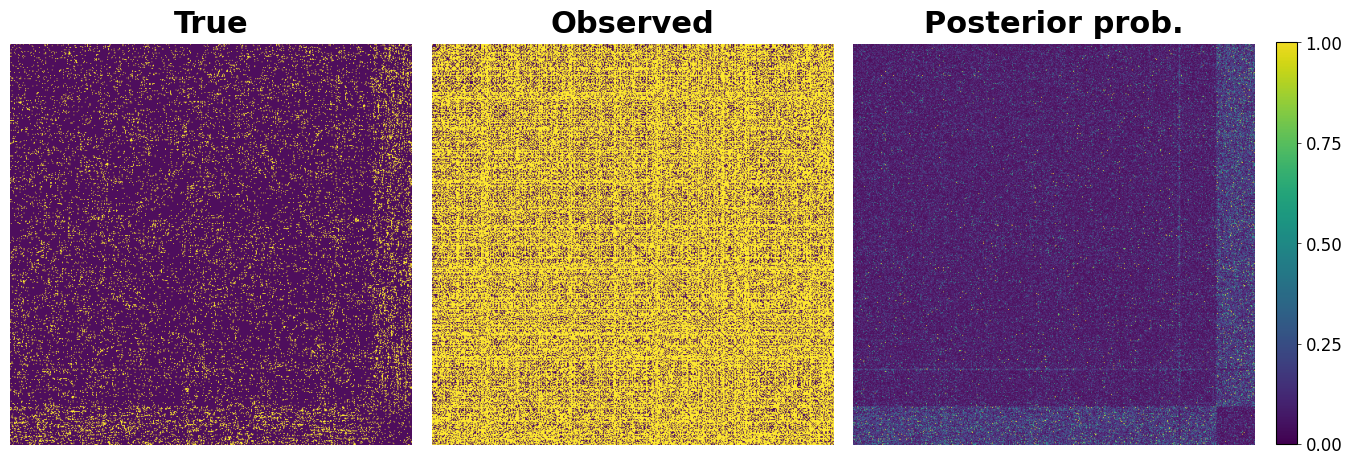

: 

: 

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 1 row × 3 cols, no special width ratios needed
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot each heatmap with vmin/vmax=0/1 and a title
for ax, data, title in zip(axes,
                           [true_ordered, observed_ordered, posterior_ordered_prob],
                           ["True", "Observed", "Posterior prob."]):
    im = ax.imshow(data, vmin=0, vmax=1, cmap="viridis", alpha=.95)
    ax.set_title(title, fontsize=22, fontweight="bold", pad=8, color="black")
    ax.axis("off")

# Create an inset axes on the right side of the third plot,
# sized to 5% of its width and 100% of its height
cax = inset_axes(axes[2],
                 width="5%",    # 5% of the axes width
                 height="100%", # 100% of the axes height
                 loc="lower left",
                 bbox_to_anchor=(1.05, 0, 1, 1),
                 bbox_transform=axes[2].transAxes,
                 borderpad=0.1)

# Draw the colorbar in that inset, with ticks from 0 to 1
cbar = fig.colorbar(im, cax=cax, ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar.set_label("Edge probability", fontsize=14, labelpad=10, color="black")
cbar.ax.tick_params(labelsize=12, length=3, width=.5, labelcolor="black", color="black")

# Tweak the outer margins so titles never get clipped
plt.subplots_adjust(left=0.05, right=0.88, top=0.88, bottom=0.05, wspace=0.05)

# plt.savefig("Simulations/results/figs/network_heatmap_prob.png", 
#             dpi=300,
#             bbox_inches="tight")

plt.show()

In [ ]:
# --- Locally informed proposal ---
# test how well gradients approximate the true differences

params = utils.ParamTuple(
    theta=THETA,
    gamma=cur_gamma,
    eta=ETA,
    rho=RHO,
    sig_inv=SIG_INV,
)

_, grads = triu_star_grad_fn(data_sim.triu_obs_rep, data_sim, params)
score_grad = -(2*data_sim.triu_obs_rep-1)*grads/2

print(score_grad.shape)

(124750,)


: 

: 

In [ ]:
# Compute manual differences of log-posterior of A* for each edge flip

@jax.jit
def flip_val(x):
    return jnp.where(x == 0.0, 1.0, 0.0)

@jax.jit
def single_flip_logpost(i, triu, data, param):
    flipped = triu.at[i].set(flip_val(triu[i]))
    return cond_logpost_a_star(flipped, data, param)


score_logdensity = jnp.zeros(TRIU_DIM) 
for i in tqdm(range(TRIU_DIM)):
    score_logdensity = score_logdensity.at[i].set(
        single_flip_logpost(i, data_sim.triu_obs_rep, data_sim, params)
        )

baseline = cond_logpost_a_star(data_sim.triu_obs_rep, data_sim, params)
score_diffs = score_logdensity - baseline



100%|██████████| 124750/124750 [49:36<00:00, 41.91it/s] 


: 

: 

: 

: 

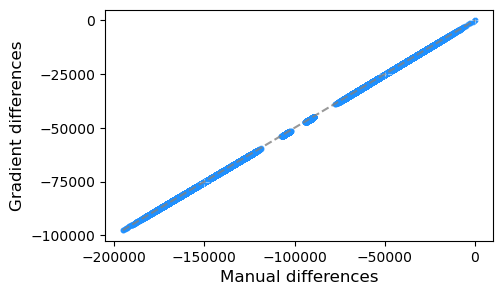

Pearson's correlation: 1.000


: 

: 

In [ ]:
# plt.scatter(score_diffs[:3000], score_grad[:3000])
# plt.scatter(jax.nn.log_softmax(score_diffs[:3000]), jax.nn.log_softmax(score_grad[:3000]))

diff_log_softmax = jax.nn.log_softmax(score_diffs)
grad_log_softmax = jax.nn.log_softmax(score_grad)

plt.figure(figsize=(5, 3))  # Adjust figure size for better clarity
plt.scatter(
    diff_log_softmax, 
    grad_log_softmax, 
    s=10,  # Reduce point size for better visualization
    color='dodgerblue',  # Choose a color that contrasts well
    alpha=0.7  # Slight transparency for overlapping points
)

min_val = min(diff_log_softmax), min(grad_log_softmax)
max_val = max(diff_log_softmax), max(grad_log_softmax)
plt.plot([min_val[0], max_val[0]], [min_val[1], max_val[1]], linestyle="--", color="gray", alpha=0.8)

plt.xlabel("Manual differences", fontsize=12)
plt.ylabel("Gradient differences", fontsize=12)

plt.xticks(np.linspace(-2e5, 0, num=5))  # Adjust number of x-axis ticks
plt.yticks(np.linspace(-1e5, 0, num=5))  # Adjust number of y-axis ticks

plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid for readability
plt.gca().set_facecolor("white")  # Ensure background is white


plt.savefig("Simulations/results/figs/diff_vs_gradient_scatter.png", 
            dpi=300,
            bbox_inches="tight")

plt.show()


print(f"Pearson's correlation: {np.corrcoef(score_diffs, score_grad)[0, 1]:.3f}")


: 

: 